# Scalar Time Series Analysis

This Analysis has a scalar time series as input and a persistent diagram as output.

In [51]:
import numpy as np
import math
import matplotlib.pyplot as plt
import networkx as nx
from scipy.sparse import csr_matrix
from gtda.time_series import SingleTakensEmbedding
from gtda.time_series import takens_embedding_optimal_parameters
from gtda.time_series import PermutationEntropy, Resampler
from gtda.graphs import GraphGeodesicDistance
from gtda.homology import VietorisRipsPersistence
import yfinance as yf

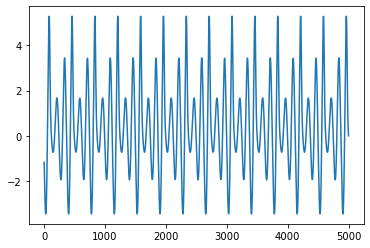

In [52]:
L = []
with open('rossler.txt') as txtfile:
    for line in txtfile:
        L.append(float(line.rstrip()))

ts_y = L[-5000:]
    
plt.plot(ts_y)
plt.show()

#### Permutation Entropy
The first two cells compute the optimal parameters for Takens Embedding by Permutation Entropy. We first fix dim = 3 and plot the tau vs Entropy curve. Choose tau at the first prominent peak. 

choose tau at the first prominent peak


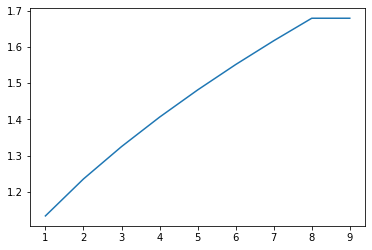

In [53]:
print('choose tau at the first prominent peak')

tau_max = 10
ti = 1
di = 3
tau = []
h = []

for x in range(1,tau_max):
    tau.append(x)
    ti = x
    STE = SingleTakensEmbedding(dimension = di, time_delay = ti)
    ts_embedded = [STE.fit_transform(ts_y)]

    PE = PermutationEntropy()
    p = PE.fit_transform(ts_embedded)
    h.append(p[0][0])
    
plt.plot(tau,h)
plt.show()

After tau was chosen, we calculate the permutation entropy for dimensions 3,4,5,6,7,8 and choose the one which maximizes pe.

In [54]:
tau = 36
d = 3
ds = [3,4,5,6,7,8]
max_h = 0

for x in ds:
    STE = SingleTakensEmbedding(dimension = x, time_delay = tau)
    ts_embedded = [STE.fit_transform(ts_y)]

    PE = PermutationEntropy()
    p = PE.fit_transform(ts_embedded)
    h = (1/(x-1))*p

    if h >= max_h:
        max_h = h
        d = x
        
print('dimension: ' + str(d))

dimension: 3


### Takens Embedding

Initialize the time series and perform Takens Embedding on it.

In [55]:
STE = SingleTakensEmbedding(parameters_type='search',
                            time_delay=300,dimension=9)
ts_embedded = STE.fit_transform(ts_y)

### Permutation Sequence

This performs the numpy argsort function on the embedded time series and shows the transitions between the permutation as time evolves. 

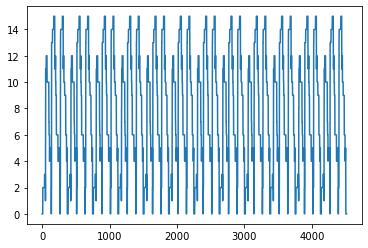

In [56]:
ps = np.argsort(ts_embedded)
u = np.unique(ps, axis=0, return_inverse=True)
y_axis = u[1]

plt.plot(y_axis)
plt.show()

### Ordinal Partition Graph

This Cell computes the ordinal partition graph resulting from the permutation sequence above. The encountered permutations are the vertex set and there is an edge between to vertices if and only if one permutation follows directly after the other. The graph is unweighted and undirected, so every edge has lenght 1.

In [57]:
n = len(u[0])
row = []
col = []
data = []

adj = [[0 for permutation in u[0]]for permutation in u[0]]

for x in range(0,len(u[1])-1):
    a = u[1][x]
    b = u[1][x+1]
    
    if a != b and adj[a][b] == 0:
        adj[a][b] += 1
        row.append(a)
        col.append(b)
        data.append(1)
        
transition_graph = csr_matrix((data, (row,col)), shape=(n,n))

Drawing the ordinal partiton graph:

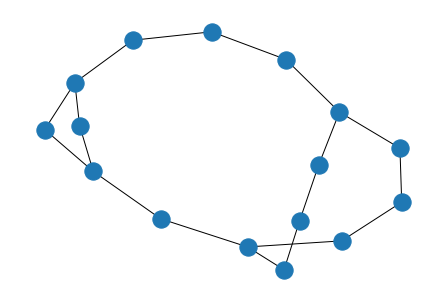

In [58]:
tg = np.any(transition_graph)
g = nx.from_scipy_sparse_matrix(tg)
nx.draw_spring(g)

plt.show()

Compute the distance matrix of the graph above by the shortest path between any two vertices:

In [59]:
dm = GraphGeodesicDistance().fit_transform([transition_graph])

### Persistence Diagram

Compute the Persistence Diagram with the Vietoris Rips Persistence. The filtration steps are the natural numbers.

In [60]:
vr = VietorisRipsPersistence(metric='precomputed',homology_dimensions = (0,1))
hom = vr.fit_transform(dm)
vr.plot(hom)

#### Point summaries of the Persistence Diagram

At first we compute the maximum persistence of all points in the diagram of dimension a. Then we return a measure of similarity of the graph above to a cycle graph with the same degree. The measure is 0 iff the graph is a cycle graph and in (0,1) otherwise.

In [61]:
def max_pers(hom,a):
    
    m = 0

    for x in hom[0]:
        if x[2] == a:
            lifetime = x[1]-x[0]
            if lifetime > m:
                m = lifetime
                
    return m

n = 1
ln = 0
p = 0

for x in hom[0]:
    if x[2] == 0:
        n += 1

ln = math.ceil(n/3)-1
p = 1 - (max_pers(hom, 1)/ln)

print(p)

0.4


This function measures the ratio of the number of homology classes to the graph order. 

In [62]:
d = 0
v = 1

for x in hom[0]:
    if x[2] == 0:
        v+=1

for x in hom[0]:
    if x[2] == 1:
        d+=1
        
print(d/v)

0.1875


The first function calculates the sum of lifetimes of points in the persistence diagram of homology dimension a. Then the normalized persistent entropy of the persistence diagram is computed.  

In [63]:
norm_entropy = 0

def sum_lifetimes(hom,a):
    l = 0
    
    for x in hom[0]:
        if x[2] == a:
            lifetime = x[1]-x[0]
            l += lifetime
            
    return l

a = 1
entropy = 0
l = sum_lifetimes(hom,a)

for x in hom[0]:
    if x[2] == a:
        lifetime = x[1]-x[0]
        z = lifetime/l
        entropy += (z*(np.log2(z)))

c = np.log2(l)
print(c)
if entropy != 0:
    entropy = -entropy
    norm_entropy = np.absolute(entropy/c)

print(entropy)
print(norm_entropy)

2.584962500721156
1.4591479170272448
0.5644754678724236
